In [172]:
from pymongo import MongoClient
import pprint

import pandas as pd
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import requests
from bs4 import BeautifulSoup

import json
import time
import copy

import os

from time import sleep
from selenium import webdriver

import script

import sys
import random
import scipy.stats as scs
import numpy as np

In [54]:
# written_review = ""
# ratings = []
# dates = []
# types = []
# review_text = []
# reviewer_links = []

In [68]:
# Mongo commands:
# driver = webdriver.Chrome()
client = MongoClient()
# client.list_database_names()
# client.drop_database()
db = client.bearmountain
db.list_collection_names()

['PopolopenTorneLoop',
 'DoodletownBridlePathLoopTrail',
 'DunderbergBaldMountainAndTheTimpLoop',
 'PerkinsMemorialTowerViaAppalachianTrail',
 'TimpTorneTrail']

In [67]:
df = pd.DataFrame(list(db.TimpTorneTrail.find({})))

# db.collection_name or db[collection_name]
# db.drop_collection('a')

soup = BeautifulSoup(df.iloc[0,2], 'html.parser')

# getting trail title, description, difficulty, info
soup.find('h1', class_='xlate-none styles-module__name___1nEtW').text.rstrip()
soup.find('p', id="auto-overview").text.rstrip()
soup.find('span', class_="styles-module__diff___22Qtv styles-module__moderate___3w1it styles-module__selected___3fawg").text.rstrip()
soup.find('span', class_="styles-module__detailData___kQ-eK").text.rstrip()

# getting reviewer data for trail, appending to lists
for i, review in enumerate(soup.find_all('div', itemprop="review")):

    ratings.append(soup.find_all('span', class_="MuiRating-root default-module__rating___1k45X MuiRating-sizeLarge MuiRating-readOnly")[i]['aria-label'])
    dates.append(soup.find_all('span', class_="styles-module__dateTrailDetails___3qgZC xlate-none")[i].text.rstrip())
    types.append(soup.find_all('span', class_="styles-module__tag___2s-oD styles-module__activityTag___3-RdN")[i].text.rstrip())

    written_review = soup.find_all('div', class_="styles-module__container___3etfA")[i].find('p', itemprop="reviewBody")

    if written_review == None:
        review_text.append(None)

    else:
        review_text.append(soup.find_all('div', class_="styles-module__container___3etfA")[i].find('p', itemprop="reviewBody").text.rstrip())        

#         reviewer_links.append('alltrails.com' + soup.find_all('div', class_="styles-module__container___3etfA")[i].find('a', class_="styles-module__link___2i6Za styles-module__recording___3jQX3 xlate-none")['href'])

In [104]:
# close Selenium ChromeDriver
# driver.close()

# collecting data into dataframe
df = pd.DataFrame({'rating': ratings[:-1], 'date':dates, 'desc': types, 'reviews': review_text}).sort_values('rating') # to be added: , 'links': reviewer_links
total_reviews = df['rating'].count()

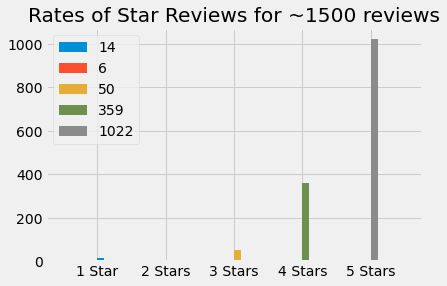

In [109]:
fig, ax = plt.subplots()
ax.hist(df[df['rating'] == '1 Star']['rating'], label=df[df['rating'] == '1 Star']['rating'].count())
ax.hist(df[df['rating'] == '2 Stars']['rating'], label=df[df['rating'] == '2 Stars']['rating'].count())
ax.hist(df[df['rating'] == '3 Stars']['rating'], label=df[df['rating'] == '3 Stars']['rating'].count())
ax.hist(df[df['rating'] == '4 Stars']['rating'], label=df[df['rating'] == '4 Stars']['rating'].count())
ax.hist(df[df['rating'] == '5 Stars']['rating'], label=df[df['rating'] == '5 Stars']['rating'].count())
ax.set_title(f'Rates of Star Reviews for ~{round(total_reviews,-2)} reviews')
_ = ax.legend()

In [125]:
df[df['rating'] == '1 Star']['reviews'].count(), df[df['rating'] == '1 Star']['rating'].count()
df_ = pd.DataFrame(
    {'stars': ['1 Star','2 Stars','3 Stars','4 Stars','5 Stars'], '% comments': [one, two, three, four, five]})

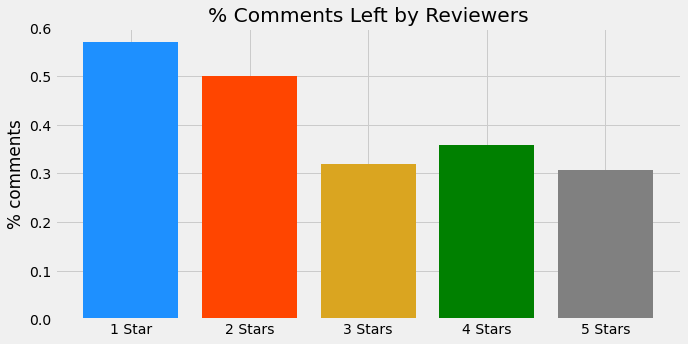

In [164]:
one = df[df['rating'] == '1 Star']['reviews'].count() / df[df['rating'] == '1 Star']['rating'].count()
two = df[df['rating'] == '2 Stars']['reviews'].count() / df[df['rating'] == '2 Stars']['rating'].count()
three = df[df['rating'] == '3 Stars']['reviews'].count() / df[df['rating'] == '3 Stars']['rating'].count()
four = df[df['rating'] == '4 Stars']['reviews'].count() / df[df['rating'] == '4 Stars']['rating'].count()
five = df[df['rating'] == '5 Stars']['reviews'].count() / df[df['rating'] == '5 Stars']['rating'].count()

x = np.arange(1,6)
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(x, df_['% comments'], color=('dodgerblue', 'orangered', 'goldenrod', 'green', 'grey'))
ax.set_xticks(x)
ax.set_xticklabels(df_['stars'])
ax.set_ylabel('% comments')
_ = ax.set_title(f'% Comments Left by Reviewers')
# _ = ax.legend()

## Comparing 4 and 5 stars

In [165]:
five = df[df['rating'] == '5 Stars']['reviews'].count() # num of written reviews left by five-star reviewers
four = df[df['rating'] == '4 Stars']['reviews'].count() # num of written reviews left by four-star reviewers
num_five = df[df['rating']=='5 Stars']['rating'].count() # num of five-star reviewers
num_four = df[df['rating']=='4 Stars']['rating'].count() # num of four-star reviewers

table = pd.DataFrame({'Written Reviews': [four, five], 'Total Reviewers': [num_four, num_five]}, index = ['4 Stars', '5 Stars']).T
table = table.style.set_properties(**{'text-align': 'center'})
table

,4 Stars,5 Stars
Written Reviews,129,313
Total Reviewers,359,1022


### Frequentist Approach

1. Question: Do 4 star and 5 star reviewers leave comments at different rates?

2. H0: Mu4 = Mu5 (4 and 5 star reviewers are equally likely to leave written reviews — P(R | 4) = P(R | 5))

3. Ha: Mu4 != Mu5 (4 and 5 star reviewers leave written reviews at different rates — P(R | 4) != P(R | 5))

4. Test Statistic: 4-Stars: 206 reviews and 5-Stars: 361 reviewers

5. Distribution: Normal

6. Alpha: 0.2

7. Data:

    4 Stars 47/206
    
    5 Stars 75/361

In [166]:
four_stars_distribution = ([0] * (359 - 129)) + ([1] * 129)
five_stars_distribution = (([0] * (1022 - 313)) + ([1] * 313))
# four_stars_prob_distribution = []
# five_stars_prob_distribution = []
# for i in four_stars_distribution:
#     four_stars_prob_distribution.append((mean_pop, 1 - mean_pop)[i])
# for i in five_stars_distribution:
#     five_stars_prob_distribution.append((mean_pop, 1 - mean_pop)[i])
print(f'Mean: \n   4 Stars {round(np.mean(four_stars_distribution),3)} \n   5 Stars {round(np.mean(five_stars_distribution),3)}\n')
print(f'Standard Deviation: \n   4 Stars {round(np.std(four_stars_distribution),3)} \n   5 Stars {round(np.std(five_stars_distribution),3)}')

Mean: 
   4 Stars 0.359 
   5 Stars 0.306

Standard Deviation: 
   4 Stars 0.48 
   5 Stars 0.461


In [173]:
# calculate welch test statistic (function in scipt.py)
test_statistic = script.welch_test_statistic(four_stars_distribution, five_stars_distribution)
test_statistic

NameError: name 'np' is not defined

In [458]:
# calculate degrees of freedom
df = welch_satterhwaithe_df(four_stars_distribution, five_stars_distribution)

# set up distribution
students = scs.t(df)

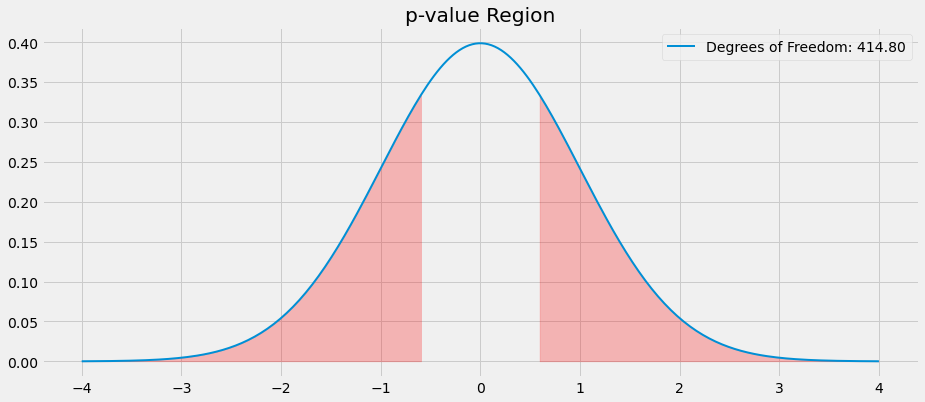

In [459]:
# Plotting distribution of Welch's Test Statistic Assuming H0

x = np.linspace(-4, 4, num=250)
fig, ax = plt.subplots(1, figsize=(14, 6))
students = scs.t(df)
ax.plot(x, students.pdf(x), linewidth=2, label="Degrees of Freedom: {:2.2f}".format(df))
_ = ax.fill_between(x, students.pdf(x), where=(x <= -test_statistic), color="red", alpha=0.25)
_ = ax.fill_between(x, students.pdf(x), where=(x >= test_statistic), color="red", alpha=0.25)
ax.legend()
ax.set_title("p-value Region");

In [447]:
p_value_ = students.cdf(-test_statistic) + (1 - students.cdf(test_statistic))
print("p-value for average written reviews: {:2.2f}".format(p_value_))

p-value for average written reviews: 0.57


8. p-value: 0.57

9. Results: Fail to reject H0.

10. In conclusion, the data fails to show a difference in the average number of written reviews left by 4-star reviewers and 5-star reviewers.